
---
#  Bayesian Parameter Estimation via MCMC
---


# Importing


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
from numpy import unravel_index
from termcolor import colored

# Data loading

In [ ]:
data= pd.read_csv('mcmc_cosmo_data.csv')
z = data['z']
D_L = data['D_L(Mpc)']
sigma_D = data['sigma_D(Mpc)']
data.head(20)

,z,D_L(Mpc),sigma_D(Mpc)
0,0.010000,53.092518,20
1,0.062105,275.738025,20
2,0.114211,543.648025,20
3,0.166316,829.223900,20
4,0.218421,1077.087212,20
5,0.270526,1374.126857,20
6,0.322632,1720.599828,20
7,0.374737,2026.914831,20
8,0.426842,2336.295625,20
9,0.478947,2701.494457,20


Extracting the redshift (z), luminosity distance (D_L), and their uncertainties (sigma_D) from the data file and converts them into NumPy arrays:

In [ ]:
z_obs_list = np.array(data['z'].tolist())
D_L_obs_list = np.array(data['D_L(Mpc)'].tolist())
sigma_D_list = np.array(data['sigma_D(Mpc)'].tolist())

Plotting a luminosity distance-redshift diagram:

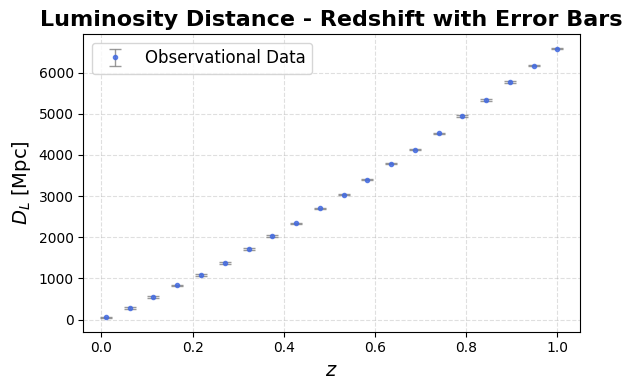

In [ ]:
plt.figure(figsize=(6, 4))
plt.errorbar(
    z_obs_list, D_L_obs_list, yerr=sigma_D_list,
    fmt='o', markersize=3, capsize=4,
    elinewidth=1, ecolor='gray', color='royalblue',
    alpha=0.8, label='Observational Data'
)

plt.xlabel('$z$', fontsize=14)
plt.ylabel('$D_L$ [Mpc]', fontsize=14)
plt.title('Luminosity Distance - Redshift with Error Bars', fontsize=16, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


 theory of luminosity distance for flat LCDM :


$$ D_L(z; H_0, \Omega_m) \approx \frac{c(1+z)}{H_0} \int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + (1-\Omega_m)}} $$

where $c = 299{,}792.458\ \text{km/s}$. we will compute it this form:

In [ ]:
# Constants
c = 299792.458  # speed of light in km/s
H0 = 70         # Hubble constant in km/s/Mpc
Omega_m = 0.25   # matter density parameter

# Function inside the integral
def integrand(z, Omega_m):
    return 1.0 / np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

# Luminosity distance function from 0 to z
def luminosity_distance(z, H0, Omega_m):
    integral, _ = quad(integrand, 0., z, args=(Omega_m,), epsrel=1e-6)
    return (c * (1 + z) / H0) * integral

def D_L_theory_for_all_zs(z_obs_list, H0, Omega_m):
    return np.array([luminosity_distance(z, H0, Omega_m) for z in z_obs_list])

# 1. Model and Likelihood
- Assume Gaussian errors $\sigma_{D_L}$ for each data point.
- The likelihood for parameters $(H_0, \Omega_m)$ is:

$$L(\mu, \sigma^2)
= \prod_{i=1}^{n}
\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\!\left[
    -\frac{(x_i - \mu)^2}{2\sigma^2}
\right]
$$


$$
\ln L(\mu, \sigma^2)
= -\frac{n}{2}\ln(2\pi)
  -\frac{n}{2}\ln(\sigma^2)
  -\frac{1}{2\sigma^2}
  \sum_{i=1}^{n}(x_i - \mu)^2
$$

Our data has the same error and the data distribution is normal we can so we simplified the likelihood by removing its normalization constant part:



$$ L(H_0, \Omega_m) \propto \exp\left( -\frac{1}{2} \sum_{i} \frac{\left[ D_{L,i}^{\text{obs}} - D_L(z_i; H_0, \Omega_m) \right]^2}{\sigma_{D_L}^2} \right) $$




In [ ]:
def log_likelihood(z_obs_list, H0, Omega_m, D_L_obs_list, sigma_D_list):
  D_L_model= D_L_theory_for_all_zs(z_obs_list, H0, Omega_m)
  main = D_L_obs_list - D_L_model
  var = sigma_D_list**2
  return -0.5 * np.sum((main**2)/var)

### 2. Set Prior Distributions as:
- $H_0 \sim \mathcal{U}(50,\, 90)$ km/s/Mpc  
- $\Omega_m \sim \mathcal{U}(0.1,\, 0.6)$

*Be careful! I will use log-prior!


In [ ]:
def prior(H0, omega_m):
  if 50 <= H0 <= 90 and 0.1 <= omega_m <= 0.6:
    return 0.0    # because log(1)=0
  return -np.inf  # because log(0)=-∞

Posterior ∝ prior + likelihood ==>  log(prior)+ log(likelihood):



In [ ]:
def log_posterior(z_obs_list,D_L_obs_list, H0, Omega_m, sigma_D_list):
  pos= prior(H0, Omega_m)
  if not np.isfinite(pos):
       return -np.inf
  return pos + log_likelihood(z_obs_list, H0, Omega_m, D_L_obs_list, sigma_D_list)

### 3. Metropolis–Hastings Implementation
- Proposal: Gaussian jumps in both parameters:

$$ H_0^{\text{new}} \sim \mathcal{N}(H_0^{\text{old}}, \delta_{H_0}^2), \quad \Omega_m^{\text{new}} \sim \mathcal{N}(\Omega_m^{\text{old}}, \delta_{\Omega_m}^2) $$

- Compute acceptance ratio:

$$ r = \frac{P_{\text{posterior}}\left(H_0^{\text{new}}, \Omega_m^{\text{new}}\right)}{P_{\text{posterior}}\left(H_0^{\text{old}}, \Omega_m^{\text{old}}\right)} $$

- Accept or reject according to $u < r$, where $u \sim U(0,1)$:

In [ ]:
def run_Metropolis_Hastings(n_steps, initial, prop_std, z_obs_list, D_L_obs_list, sigma_D_list, thin=1, burn=0):
    # initial point: (H0, Om)
    H0_start, Om_start = initial
    log_posterior_start = log_posterior(z_obs_list, D_L_obs_list, H0_start, Om_start, sigma_D_list)
    samples = []
    n_accept = 0

    for i in range(n_steps):
        # propose
        H0_prop = np.random.normal(H0_start, prop_std[0])
        Om_prop = np.random.normal(Om_start, prop_std[1])
        log_posterior_prop = log_posterior(z_obs_list, D_L_obs_list, H0_prop, Om_prop, sigma_D_list)

           # acceptance (work in log-space)
        if not np.isfinite(log_posterior_prop):
            accept = False
        else:
          #This is the logarithm of the acceptance ratio log(r):
            log_alpha = log_posterior_prop - log_posterior_start
            if log_alpha >= 0:
                accept = True
             #We draw a random number between 0 and 1 to decide whether to accept a worse proposal,
             #so that points with lower posterior probability still have a small chance to be accepted,
             #allowing the chain to explore the whole parameter space instead of getting stuck in local maxima.
            else:
                u = np.log(np.random.rand())
                accept = (u < log_alpha)

        if accept:
            H0_start, Om_start = H0_prop, Om_prop
            log_posterior_start = log_posterior_prop
            n_accept += 1

        if i >= burn and ((i - burn) % thin == 0):
            samples.append((H0_start, Om_start))

    samples = np.array(samples)
    acc_rate = n_accept / n_steps
    return samples, acc_rate

RUN the algorithm:

In [ ]:
import time

start_time = time.time()


np.random.seed(42)

#  parameters
n_steps = 50000          # number of MH steps
initial = (70.0, 0.25)   # initial (H0, Omega_m)
prop_std = (0.2, 0.002)  # proposal stds for H0, Omega_m

#  run the Metropolis-Hastings

#Burn-in: The initial part of the MCMC chain that is discarded because the sampler
# has not yet reached the high-probability (stationary) region of the posterior.

#Thinning: Keeping only every n-th sample from the chain to reduce correlation
#between consecutive samples and make them more independent.
samples, acc_rate = run_Metropolis_Hastings(n_steps,initial,prop_std,z_obs_list,D_L_obs_list,sigma_D_list, thin=5, burn=5000)


print(colored("──────────────────────────────", "cyan"))
print(colored("✅ Metropolis–Hastings Results", "yellow", attrs=["bold"]))
print(colored("──────────────────────────────", "cyan"))
print(colored(f"Acceptance rate: {acc_rate*100:.1f}%\n", "green"))


H0_samples = samples[:, 0]
Omega_m_samples = samples[:, 1]

#  posterior summaries
H0_med = np.median(H0_samples)
Om_med = np.median(Omega_m_samples)


# credible intervals
H0_CI_1σ = np.percentile(H0_samples, [16, 84])
H0_CI_2σ = np.percentile(H0_samples, [2.5, 97.5])
H0_CI_3σ = np.percentile(H0_samples, [0.15, 99.85])

Om_CI_1σ = np.percentile(Omega_m_samples, [16, 84])
Om_CI_2σ = np.percentile(Omega_m_samples, [2.5, 97.5])
Om_CI_3σ = np.percentile(Omega_m_samples, [0.15, 99.85])

# output
print(colored("📏 Parameter Estimates (Posterior Summary)", "magenta", attrs=["bold"]))
print(colored("──────────────────────────────────────────────", "cyan"))

print(colored(f"H₀ (Hubble constant):", "blue"),
      colored(f"{H0_med:.3f}", "white"))
print(colored("  1σ interval:", "green"), f"[{H0_CI_1σ[0]:.2f}, {H0_CI_1σ[1]:.2f}]")
print(colored("  2σ interval:", "yellow"), f"[{H0_CI_2σ[0]:.2f}, {H0_CI_2σ[1]:.2f}]")
print(colored("  3σ interval:", "red"), f"[{H0_CI_3σ[0]:.2f}, {H0_CI_3σ[1]:.2f}]")

print()

print(colored(f"Ωₘ (Matter density):", "blue"),
      colored(f"{Om_med:.4f}", "white"))
print(colored("  1σ interval:", "green"), f"[{Om_CI_1σ[0]:.4f}, {Om_CI_1σ[1]:.4f}]")
print(colored("  2σ interval:", "yellow"), f"[{Om_CI_2σ[0]:.4f}, {Om_CI_2σ[1]:.4f}]")
print(colored("  3σ interval:", "red"), f"[{Om_CI_3σ[0]:.4f}, {Om_CI_3σ[1]:.4f}]")

print(colored("──────────────────────────────────────────────", "cyan"))

print(colored("──────────────────────────────────────────", "cyan"))

end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds")








──────────────────────────────
✅ Metropolis–Hastings Results
──────────────────────────────
Acceptance rate: 43.0%

📏 Parameter Estimates (Posterior Summary)
──────────────────────────────────────────────
H₀ (Hubble constant): 69.594
  1σ interval: [69.13, 70.02]
  2σ interval: [68.55, 70.39]
  3σ interval: [67.95, 70.87]

Ωₘ (Matter density): 0.3172
  1σ interval: [0.3047, 0.3308]
  2σ interval: [0.2945, 0.3485]
  3σ interval: [0.2811, 0.3662]
──────────────────────────────────────────────
──────────────────────────────────────────
Runtime: 57.23 seconds


# Plotes :

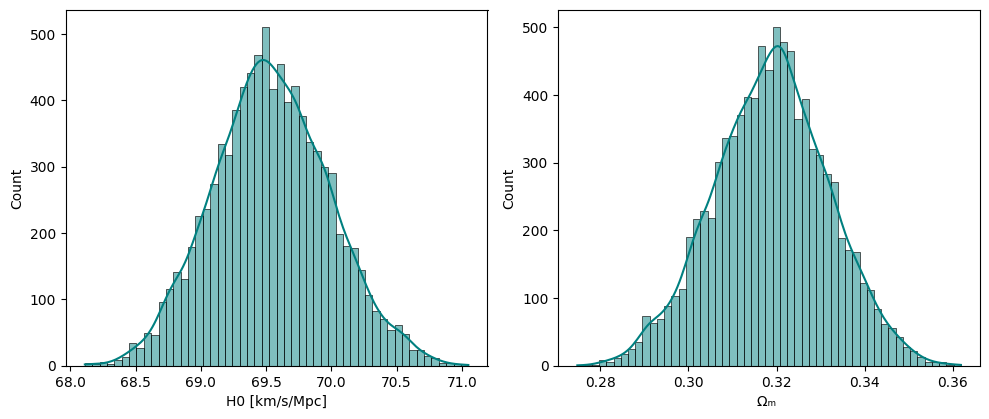

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
sns.histplot(H0_samples, kde=True, color='teal')
plt.xlabel('H0 [km/s/Mpc]')
plt.subplot(2,2,2)
sns.histplot(Omega_m_samples, kde=True, color='teal')
plt.xlabel('Ωₘ ')
plt.tight_layout()
plt.show()


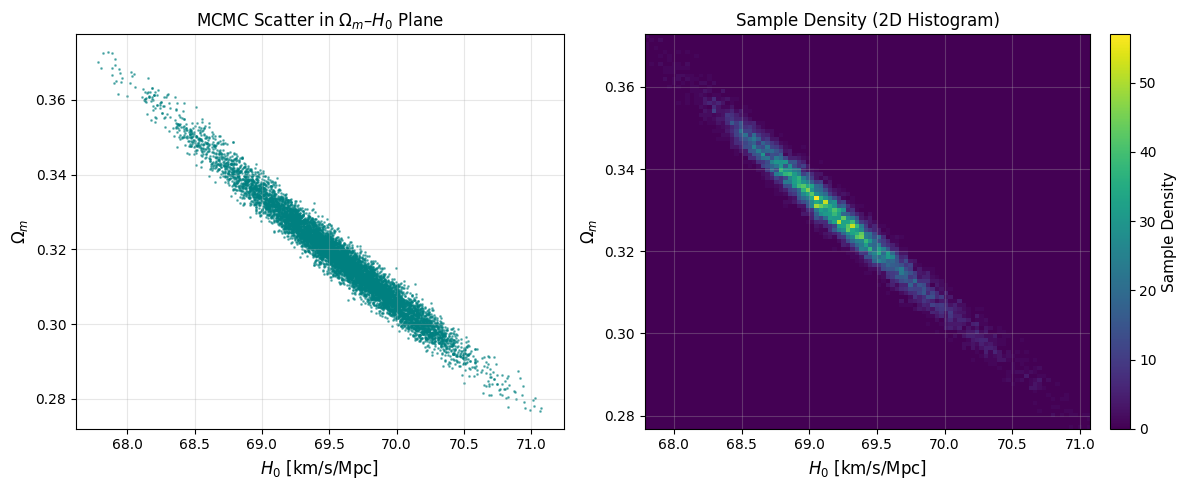

In [ ]:
# Create 2D histogram
H, xedges, yedges = np.histogram2d(H0_samples, Omega_m_samples, bins=100)

# Create the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Scatter plot
axes[0].scatter(H0_samples, Omega_m_samples, s=1, alpha=0.5, color='teal')
axes[0].set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=12)
axes[0].set_ylabel(r'$\Omega_m$', fontsize=12)
axes[0].set_title('MCMC Scatter in $\\Omega_m$–$H_0$ Plane', fontsize=12)
axes[0].grid(alpha=0.3)

# Right: 2D Histogram
im = axes[1].imshow(
    H.T,
    origin='lower',
    aspect='auto',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='viridis'
)
axes[1].set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=12)
axes[1].set_ylabel(r'$\Omega_m$', fontsize=12)
axes[1].set_title('Sample Density (2D Histogram)', fontsize=12)
axes[1].grid(alpha=0.3)

# Colorbar for the second plot
cbar = fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
cbar.set_label('Sample Density', fontsize=11)
plt.tight_layout()
plt.show()


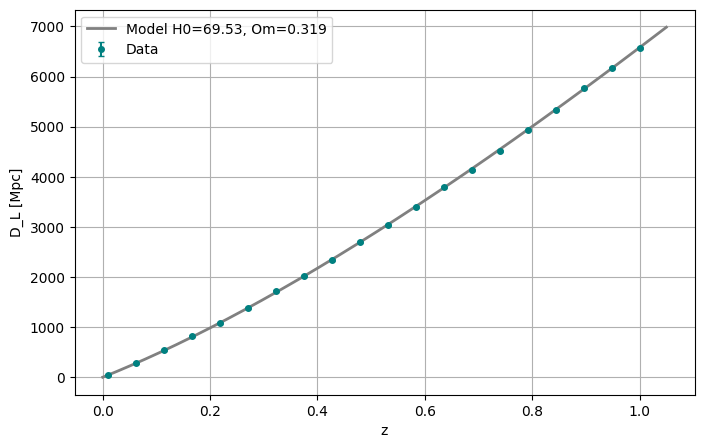

In [ ]:
# Compare best-fit (median) model with data
z_plot = np.linspace(0, max(z_obs_list)*1.05, 200)
D_model_plot = D_L_theory_for_all_zs(z_plot, H0_med, Om_med)

plt.figure(figsize=(8,5))
plt.errorbar(z_obs_list, D_L_obs_list, yerr=sigma_D_list, fmt='o', markersize=4, capsize=2, label='Data', color='teal')
plt.plot(z_plot, D_model_plot, label=f'Model H0={H0_med:.2f}, Om={Om_med:.3f}', lw=2, color='gray')
plt.xlabel('z'); plt.ylabel('D_L [Mpc]')
plt.legend(); plt.grid(True)
plt.show()

# Now we discuss how changing proposal widths  δH0  and  δΩm  affects convergence.

prop_std(old) = (0.5, 0.0005) --> prop_std(new) = (10, 0.1)

In [ ]:
import time

start_time = time.time()


np.random.seed(42)
#  parameters
n_steps = 50000          # number of MH steps
initial = (70.0, 0.25)   # initial (H0, Omega_m)
prop_std = (10, 0.1)  # proposal stds for H0, Omega_m

#  run the Metropolis-Hastings
samples, acc_rate = run_Metropolis_Hastings(n_steps,initial,prop_std,z_obs_list,D_L_obs_list,sigma_D_list, thin=5, burn=5000)


print(colored("──────────────────────────────", "cyan"))
print(colored("✅ Metropolis–Hastings Results", "yellow", attrs=["bold"]))
print(colored("──────────────────────────────", "cyan"))
print(colored(f"Acceptance rate: {acc_rate*100:.1f}%\n", "green"))


H0_samples = samples[:, 0]
Omega_m_samples = samples[:, 1]

#  posterior summaries
H0_med = np.median(H0_samples)
Om_med = np.median(Omega_m_samples)

H0_CI = np.percentile(H0_samples, [16, 84])
Om_CI = np.percentile(Omega_m_samples, [16, 84])



#credible intervals
H0_CI_1σ = np.percentile(H0_samples, [16, 84])
H0_CI_2σ = np.percentile(H0_samples, [2.5, 97.5])
H0_CI_3σ = np.percentile(H0_samples, [0.15, 99.85])

Om_CI_1σ = np.percentile(Omega_m_samples, [16, 84])
Om_CI_2σ = np.percentile(Omega_m_samples, [2.5, 97.5])
Om_CI_3σ = np.percentile(Omega_m_samples, [0.15, 99.85])

#  output
print(colored("📏 Parameter Estimates (Posterior Summary)", "magenta", attrs=["bold"]))
print(colored("──────────────────────────────────────────────", "cyan"))

print(colored(f"H₀ (Hubble constant):", "blue"),
      colored(f"{H0_med:.3f}", "white"))
print(colored("  1σ interval:", "green"), f"[{H0_CI_1σ[0]:.2f}, {H0_CI_1σ[1]:.2f}]")
print(colored("  2σ interval:", "yellow"), f"[{H0_CI_2σ[0]:.2f}, {H0_CI_2σ[1]:.2f}]")
print(colored("  3σ interval:", "red"), f"[{H0_CI_3σ[0]:.2f}, {H0_CI_3σ[1]:.2f}]")

print()

print(colored(f"Ωₘ (Matter density):", "blue"),
      colored(f"{Om_med:.4f}", "white"))
print(colored("  1σ interval:", "green"), f"[{Om_CI_1σ[0]:.4f}, {Om_CI_1σ[1]:.4f}]")
print(colored("  2σ interval:", "yellow"), f"[{Om_CI_2σ[0]:.4f}, {Om_CI_2σ[1]:.4f}]")
print(colored("  3σ interval:", "red"), f"[{Om_CI_3σ[0]:.4f}, {Om_CI_3σ[1]:.4f}]")

print(colored("──────────────────────────────────────────────", "cyan"))


end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds")

──────────────────────────────
✅ Metropolis–Hastings Results
──────────────────────────────
Acceptance rate: 0.2%

📏 Parameter Estimates (Posterior Summary)
──────────────────────────────────────────────
H₀ (Hubble constant): 69.508
  1σ interval: [69.11, 69.95]
  2σ interval: [68.58, 70.52]
  3σ interval: [68.36, 71.00]

Ωₘ (Matter density): 0.3190
  1σ interval: [0.3054, 0.3324]
  2σ interval: [0.2931, 0.3471]
  3σ interval: [0.2750, 0.3551]
──────────────────────────────────────────────
Runtime: 23.18 seconds




prop_std(old) = (0.5, 0.0005) --> prop_std(new) = (0,05, 0.0005)

In [ ]:
import time

start_time = time.time()

np.random.seed(42)

#  parameters
n_steps = 50000          # number of MH steps
initial = (70.0, 0.25)   # initial (H0, Omega_m)
prop_std = (0.05, 0.0005)  # proposal stds for H0, Omega_m

#  run the Metropolis-Hastings
samples, acc_rate = run_Metropolis_Hastings(n_steps,initial,prop_std,z_obs_list,D_L_obs_list,sigma_D_list, thin=5, burn=5000)


print(colored("──────────────────────────────", "cyan"))
print(colored("✅ Metropolis–Hastings Results", "yellow", attrs=["bold"]))
print(colored("──────────────────────────────", "cyan"))
print(colored(f"Acceptance rate: {acc_rate*100:.1f}%\n", "green"))


H0_samples = samples[:, 0]
Omega_m_samples = samples[:, 1]

#  posterior summaries
H0_med = np.median(H0_samples)
Om_med = np.median(Omega_m_samples)



# credible intervals
H0_CI_1σ = np.percentile(H0_samples, [16, 84])
H0_CI_2σ = np.percentile(H0_samples, [2.5, 97.5])
H0_CI_3σ = np.percentile(H0_samples, [0.15, 99.85])

Om_CI_1σ = np.percentile(Omega_m_samples, [16, 84])
Om_CI_2σ = np.percentile(Omega_m_samples, [2.5, 97.5])
Om_CI_3σ = np.percentile(Omega_m_samples, [0.15, 99.85])

# output
print(colored("📏 Parameter Estimates (Posterior Summary)", "magenta", attrs=["bold"]))
print(colored("──────────────────────────────────────────────", "cyan"))

print(colored(f"H₀ (Hubble constant):", "blue"),
      colored(f"{H0_med:.3f}", "white"))
print(colored("  1σ interval:", "green"), f"[{H0_CI_1σ[0]:.2f}, {H0_CI_1σ[1]:.2f}]")
print(colored("  2σ interval:", "yellow"), f"[{H0_CI_2σ[0]:.2f}, {H0_CI_2σ[1]:.2f}]")
print(colored("  3σ interval:", "red"), f"[{H0_CI_3σ[0]:.2f}, {H0_CI_3σ[1]:.2f}]")

print()

print(colored(f"Ωₘ (Matter density):", "blue"),
      colored(f"{Om_med:.4f}", "white"))
print(colored("  1σ interval:", "green"), f"[{Om_CI_1σ[0]:.4f}, {Om_CI_1σ[1]:.4f}]")
print(colored("  2σ interval:", "yellow"), f"[{Om_CI_2σ[0]:.4f}, {Om_CI_2σ[1]:.4f}]")
print(colored("  3σ interval:", "red"), f"[{Om_CI_3σ[0]:.4f}, {Om_CI_3σ[1]:.4f}]")

print(colored("──────────────────────────────────────────────", "cyan"))


end_time = time.time()
print(f"Runtime: {end_time - start_time:.2f} seconds")

──────────────────────────────
✅ Metropolis–Hastings Results
──────────────────────────────
Acceptance rate: 81.2%

📏 Parameter Estimates (Posterior Summary)
──────────────────────────────────────────────
H₀ (Hubble constant): 69.662
  1σ interval: [69.17, 70.08]
  2σ interval: [68.41, 70.52]
  3σ interval: [68.09, 70.80]

Ωₘ (Matter density): 0.3151
  1σ interval: [0.3031, 0.3298]
  2σ interval: [0.2906, 0.3538]
  3σ interval: [0.2837, 0.3636]
──────────────────────────────────────────────
Runtime: 47.18 seconds


# **Discuss how changing proposal widths  δH0  and  δΩm  affects convergence:**
When using small proposal widths (δH₀=0.05, δΩₘ=0.0005), acceptance rate becomes very high (> 70–80%).But If proposal widths are too large (10, 0.1) the sampler often proposes points far from regions of high probability.Those points get rejected frequently, because their posterior values are much lower and the acceptance rate becomes too low (< 10%)

There is an optimal proposal width that balances exploration and acceptance .Typically, we want an acceptance rate between 20% and 50%.


In [ ]:
data = {
    "Proposal width (prop_std)": [
        "(0.05, 0.0005)",
        "(0.2, 0.002)",
        "(10, 0.1)"
    ],
    "Acceptance rate": [
        "High (81.2%)",
        "Moderate (43.0%)",
        "Low (0.2%)"
    ]
}

table = pd.DataFrame(data)

print(table.to_string(index=False))


Proposal width (prop_std)  Acceptance rate
           (0.05, 0.0005)     High (81.2%)
             (0.2, 0.002) Moderate (43.0%)
                (10, 0.1)       Low (0.2%)
